we start by mounting our drive, i had to use google colab in the end due to the need for more computing power, because the data is soo large


In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


Here we Import all the dependencies that are required

In [ ]:
pip install pyod

In [ ]:
import matplotlib as mpl
import plotly.express as px
import pandas as pd
import matplotlib.pyplot as plt
import os
import plotly.graph_objects as go
import seaborn as sns
import numpy as np
import zipfile
from datetime import timedelta
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
#from pyod.models.iforest import IForest
from sklearn.preprocessing import StandardScaler
from matplotlib.ticker import MultipleLocator


mpl.rcParams['figure.figsize'] = (10,8)
mpl.rcParams['axes.grid'] = False

We break down the metadata names and store them in a list, the first one
hold the features that we believe are most important (rssi, rsrp and rsrq), and the second one will hold the additional metadata that we feel might be useful we would need confirmation on which ones to add

In [ ]:
#meta_types2 = ['band', 'device_state','lte_freq', 'mode']
meta_types = ['rssi','rsrp', 'rsrq', 'band', 'device_state','lte_freq','mode']

We use the next two lines, to visualise the data, both the event and the 1 min bin data, to see if the event data has enough observations, which have registered a change in that particular feature, for earfcn most importantly, we notice there is not much change, thats why i dropped it from the initial list.

In [ ]:
visual = pd.read_csv('/content/drive/MyDrive/rawdata/rawdata/metadata_mode_events.csv')
visual2 = pd.read_csv('/content/drive/MyDrive/rawdata/rawdata/metadata_mode_1min_bin.csv')

In [ ]:
visual[(visual['node_id'] == 4135)& (visual['network_id'] == 2)].head(60)
#visual2[(visual2['node_id'] == 4135)& (visual2['network_id'] == 2) & (visual2['mode'] == 0 )]

In the function  below we store our  rtt data as a dataframe, the data had been extracted and combined in another notebook called datacombination.ipynb, this code basically creates the bin_ts in minutes and the event_ts in seconds precision, also filters the data based on network ID.

This is because in our previous discussion we mentioned to focus on Telia, and with the data being very high dimensional the earlier i filter it the better.




In [ ]:
def process_packet_data(csv_path, network_id):
    # Read the CSV file
    df_packet = pd.read_csv(csv_path)

    # Convert the 'ts' column to datetime
    df_packet['ts'] = pd.to_datetime(df_packet['ts'])

    # Round the 'ts' column to the nearest second
    df_packet["bin_ts"] = df_packet["ts"].dt.floor(freq="min")

    # I need pivot columns for merging events with frequency of 1 Second
    df_packet["event_ts"] = df_packet["ts"].dt.floor(freq="s")

    # Filter rows based on the specified network_id
    df_filtered = df_packet[df_packet['network_id'] == network_id]

    return df_filtered

This function processes each event and bin meta data and merge it with the rtt dataframe

In [ ]:
def process_metadata(m, node_id_val, network_id_val, df_initial, is_bin=False):
    # Determine file path based on whether it's bin data
    file_suffix = "1min_bin" if is_bin else "events"
    df_meta = pd.read_csv(f'/content/drive/MyDrive/rawdata/rawdata/metadata_{m}_{file_suffix}.csv')

    # Convert 'ts' column to datetime and filter
    df_meta['ts'] = pd.to_datetime(df_meta['ts'])
    df_filtered = df_meta[(df_meta['node_id'] == node_id_val) & (df_meta['network_id'] == network_id_val)].copy()
    if is_bin == False:
      df_filtered = adjust_event_timestamps(df_filtered, 'ts')

    # Round 'ts' column and drop original 'ts' column
    time_col = "bin_ts" if is_bin else "event_ts"
    df_filtered[time_col] = df_filtered["ts"].dt.floor(freq="min" if is_bin else "s")
    df_filtered = df_filtered.drop(columns='ts')

    # Merge and forward fill
    merge_cols = ['node_id', 'network_id', time_col]
    df_merged = pd.merge(df_initial, df_filtered, on=merge_cols, how='left')

    # Forward fill the specific event column, rename it to follow the naming convention
    event_col_name = f'event_{m}'
    if is_bin:
        event_col_name = f'Bin_{m}'
    if is_bin == False:
      fill_initial_event(df_merged, 'event_ts', m, f'Bin_{m}','2023-11-01 00:00:00')
    df_merged[m] = df_merged[m].fillna(method="ffill")
    df_merged.reset_index(drop=True, inplace=True)
    df_merged.rename(columns={m: event_col_name}, inplace=True)


    return df_merged

This is used to adjust the event metadata to avoid multiple occurence on the same second value, by shifting the observation to the next second

In [ ]:
def adjust_event_timestamps(df, timestamp_col):
    # Ensure the DataFrame is sorted by the timestamp column
    df_sorted = df.sort_values(by=timestamp_col).copy()

    # Initialize the 'adjusted_timestamp' column with the original timestamps
    df_sorted['adjusted_timestamp'] = df_sorted[timestamp_col]

    # Iterate through the DataFrame to adjust timestamps where necessary
    for i in range(1, len(df_sorted)):
        # If the current event occurs within the same second as the previous event
        if df_sorted.iloc[i][timestamp_col].replace(microsecond=0) == df_sorted.iloc[i-1]['adjusted_timestamp'].replace(microsecond=0):
            # Set the current event's adjusted timestamp one second greater than the previous event's adjusted timestamp
            df_sorted.at[i, 'adjusted_timestamp'] = df_sorted.iloc[i-1]['adjusted_timestamp'] + timedelta(seconds=1)

    # Drop the original timestamp column
    df_sorted.drop(columns=[timestamp_col], inplace=True)

    # Rename 'adjusted_timestamp' column to the original timestamp column name
    df_sorted.rename(columns={'adjusted_timestamp': timestamp_col}, inplace=True)

    return df_sorted

This is used for copying the initial Bin value to the event column in cases where the first event value is a NAN

In [ ]:
def fill_initial_event(df, timestamp_col, event_col, bin_col, specific_timestamp):

    # Fill the NaN value in 'event_col' at the specific timestamp with the value from 'bin_col'
    condition = (df[timestamp_col] == specific_timestamp) & (df[event_col].isna())
    if df.loc[condition].shape[0] > 0:
        df.loc[condition, event_col] = df.loc[condition, bin_col]

    return df

This is the function that contains the main loop for my merging, it first processes the rtt data and then merges the meta data to it and gives out a dataframe in the end

In [ ]:
def merge_data2(packet_csv_path, node_id, network_id, meta_types):
    df_initial = process_packet_data(packet_csv_path, network_id)

    for m in meta_types:
        # Process bin data
        df_initial = process_metadata(m, node_id, network_id, df_initial, is_bin=True)

        # Process event data
        df_initial = process_metadata(m, node_id, network_id, df_initial, is_bin=False)


    #df_initial.dropna(inplace=True)
    df_initial.reset_index(drop=True, inplace=True)

    return df_initial

This is a function solely to clean the data based on unreasonable values, and what the acceptable range for some of the features should be within the data, i still need confirmation before i implement some of this.

In [ ]:
def clean_data(data):
  #data.dropna(inplace=True)
  data = data[(data['scnt'] == 1) & (data['rcnt'] == 1)]
  data= data[(data['Bin_mode'] == 6)]
  data_sorted = data.sort_values(by='ts')
  data_no_duplicates = data_sorted.drop_duplicates(subset='ts', keep='first')
  data_no_duplicates.reset_index(drop=True, inplace=True)
  columns_to_drop = ['network_id', 'service_id','Bin_mode', 'event_mode', 'Bin_rssi',
                     'rcnt', 'scnt', 'bin_ts', 'event_ts',  'Bin_rsrp',  'Bin_rsrq',
                     'Bin_device_state', 'Bin_lte_freq', 'Bin_band']
  data = data_no_duplicates.drop(columns=columns_to_drop, axis=1)
  #data = data[(data['event_rsrq'] >= -20)& (data['Bin_rsrq'] >= -20)]
  #data = data[(data['event_rsrp'] >= -100)& (data['Bin_rsrq'] >= -100)]
  return data

I try to parse my Oslo 4120 data into the functions and get the output

In [ ]:
path = '/content/drive/MyDrive/combined_4144oslo_df.csv'
net_id = 2
node_id = 4144
Oslo_4144 = merge_data2(path, node_id, net_id, meta_types)
oslo_4144 = clean_data(Oslo_4144)

In [ ]:
oslo_4144

In [ ]:
path = '/content/drive/MyDrive/combined_4147_df.csv'
net_id = 2
node_id = 4147
Oslo_4147 = merge_data2(path, node_id, net_id, meta_types)
oslo_4147 = clean_data(Oslo_4147)

In [ ]:
path = '/content/drive/MyDrive/combined_4135tromso_df.csv'
net_id = 2
node_id = 4135
Tromso_4135 = merge_data2(path, node_id, net_id, meta_types)

In [ ]:
tromso_4135 = clean_data(Tromso_4135)

In [ ]:
path = '/content/drive/MyDrive/4126vbergen_df.csv'
net_id = 2
node_id = 4126
bergen = merge_data2(path, node_id, net_id, meta_types)

In [ ]:
Bergen = clean_data(bergen)

In [ ]:
path = '/content/drive/MyDrive/bud_4152.csv'
net_id = 2
node_id = 4152
bud_4152= merge_data2(path, node_id, net_id, meta_types)
Bud= clean_data(bud_4152)

In [ ]:
Bud.to_csv('/content/drive/My Drive/bud_4152_ready.csv', index=False)

,ts,node_id,rtt,event_rssi,event_rsrp,event_rsrq,event_band,event_device_state,event_lte_freq
0,2023-11-01 00:00:00.372102,4152,0.051132,-80.0,-112.0,-12.0,3.0,3.0,1800.0
1,2023-11-01 00:00:01.373157,4152,0.050266,-80.0,-111.0,-12.0,3.0,3.0,1800.0
2,2023-11-01 00:00:02.374228,4152,0.048981,-80.0,-111.0,-12.0,3.0,3.0,1800.0
3,2023-11-01 00:00:03.375309,4152,0.047081,-80.0,-111.0,-12.0,3.0,3.0,1800.0
4,2023-11-01 00:00:04.375950,4152,0.047388,-80.0,-111.0,-12.0,3.0,3.0,1800.0
...,...,...,...,...,...,...,...,...,...
4969093,2023-12-31 23:59:55.031659,4152,0.052416,-71.0,-104.0,-15.0,20.0,3.0,800.0
4969094,2023-12-31 23:59:56.032708,4152,0.051409,-71.0,-104.0,-15.0,20.0,3.0,800.0
4969095,2023-12-31 23:59:57.033755,4152,0.052315,-71.0,-104.0,-16.0,20.0,3.0,800.0
4969096,2023-12-31 23:59:58.034802,4152,0.051305,-71.0,-104.0,-15.0,20.0,3.0,800.0


In [ ]:
path = '/content/drive/MyDrive/combined_4137gelio_df.csv'
net_id = 2
node_id = 4137
Gelio_4137 = merge_data2(path, node_id, net_id, meta_types)
gelio_4137 = clean_data(Gelio_4137)

In [ ]:
tromso_4135 = pd.read_csv('/content/drive/MyDrive/Tromso4135_unclean.csv')
oslo_4144 =  pd.read_csv('/content/drive/MyDrive/Oslo4144_unclean.csv')
oslo_4147 = pd.read_csv('/content/drive/MyDrive/Oslo4147_unclean.csv')
gelio_4137 = pd.read_csv('/content/drive/MyDrive/Gelio4137_unclean.csv')
bud_4152 =  pd.read_csv('/content/drive/MyDrive/bud_4152_ready.csv')

In [ ]:
duplicates = tromso_4135_c.duplicated(keep=False)
duplicate_rows = tromso_4135_c[duplicates]

In [ ]:
duplicate_rows

,ts,node_id,rtt,Bin_rssi,event_rssi,Bin_rsrp,event_rsrp,Bin_rsrq,event_rsrq,Bin_band,event_band,Bin_device_state,event_device_state,Bin_lte_freq,event_lte_freq


In [ ]:
gelio_4137_c = clean_data(gelio_4137)
oslo_4144_c = clean_data(oslo_4144)
oslo_4147_c = clean_data(oslo_4147)
tromso_4135_c = clean_data(tromso_4135)

This code below combines the data from the different nodes for us to visualize and test

In [ ]:
def week_data(df1, df2, df3, df4,df5, num, rtt_column='rtt'):
    # Convert timestamp columns to datetime
    df1['ts'] = pd.to_datetime(df1['ts'])
    df2['ts'] = pd.to_datetime(df2['ts'])
    df3['ts'] = pd.to_datetime(df3['ts'])
    df4['ts'] = pd.to_datetime(df4['ts'])
    df5['ts'] = pd.to_datetime(df5['ts'])

    # Determine the week-long period based on the earliest timestamp in all dataframes
    start_date = min(df1['ts'].min(), df2['ts'].min(), df3['ts'].min(), df4['ts'].min(),df5['ts'].min())
    end_date = start_date + pd.Timedelta(days=num)

    # Filter each dataframe for the week-long period
    df1_week = df1[(df1['ts'] >= start_date) & (df1['ts'] <= end_date)]
    df2_week = df2[(df2['ts'] >= start_date) & (df2['ts'] <= end_date)]
    df3_week = df3[(df3['ts'] >= start_date) & (df3['ts'] <= end_date)]
    df4_week = df4[(df4['ts'] >= start_date) & (df4['ts'] <= end_date)]
    df5_week = df5[(df5['ts'] >= start_date) & (df5['ts'] <= end_date)]

    # Combine all four dataframes
    combined_df = pd.concat([df1_week, df2_week, df3_week, df4_week,df5_week], ignore_index=True)
    combined_df = combined_df.sort_values(by='ts')

    return combined_df

this code is used to calculate the mean, median and standard deviation for the plots

In [ ]:
def calculate_stats_by_node(df, value_column='rtt'):
    # Group by node ID and calculate mean, median, and standard deviation
    stats_by_node = df.groupby('node_id')[value_column].agg(['mean', 'median', 'std']).to_dict()

    stats_dict = {
        f'{value_column}_mean': stats_by_node['mean'],
        f'{value_column}_median': stats_by_node['median'],
        f'{value_column}_std': stats_by_node['std']
    }

    return stats_dict

This plot is basically for a box plot

In [ ]:
def boxplot_data(data, stats):
    plt.figure(figsize=(20, 12))
    sns.boxplot(data= data, x='node_id', y='rtt', palette='Set2')
    legend_labels = [f'{city_dict.get(node_id, f"City {node_id}")} {node_id} (Median: {stats["rtt_median"][node_id]:.4f})' for node_id in stats['rtt_mean'].keys()]
    plt.title(f'RTT Distribution by Node ID for Selected Week')
    plt.xlabel('Node ID')
    plt.ylabel('RTT in seconds')
    plt.legend(legend_labels, title='Cities and Node IDs', loc='outside upper right')
    plt.ylim(0, 200)
    plt.show()

In [ ]:
def violin_data(data, stats):
  plt.figure(figsize=(20, 12))
  sns.violinplot(x='node_id', y='rtt', data=data, palette='Set2')
  legend_labels =[f'{city_dict.get(node_id, f"City {node_id}")} {node_id}' for node_id in stats['rtt_mean'].keys()]
  # Customize plot labels and title
  plt.title('RTT Distribution by Node ID for Selected Week')
  plt.xlabel('Node ID')
  plt.ylabel('RTT in seconds')
  plt.legend(legend_labels, title='Cities and Node IDs', loc='outside upper right')
  plt.ylim(0, .2)

  # Show the plot
  plt.show()

This is a time series plot using plotly which is an interactive plot for the data

In [ ]:
def plot_time_series(df, timestamp_col, value_col, title='RTT Plot', y_range=None):
    # Ensure the timestamp column is in datetime format and set it as the DataFrame index
    #df[timestamp_col] = pd.to_datetime(df[timestamp_col])
    #df = df.set_index(timestamp_col)

    df = df.resample('T').mean().reset_index()

    # Reset the index to use the timestamp column for plotting
    df_reset = df.reset_index()


    # Create the plot
    fig = px.line(df_reset, x=timestamp_col, y=value_col, title=title)

    # Update Y-axis range if specified
    if y_range is not None:
        fig.update_yaxes(range=y_range)

    # Update X-axis for the range slider
    fig.update_xaxes(rangeslider_visible=True)

    # Show the plot
    fig.show()

In [ ]:
city_dict = {4144: 'Oslo', 4147: 'Oslo', 4135: 'Tromso', 4137 : 'Gelio', 4152 : 'Bud'}

In [ ]:
def seasonality_plot(df):
    # Set index to 'ts'
    df.set_index('ts', inplace=True)

    # Create 'hour' column
    df['hour'] = df.index.hour

    # Create 'day_of_week' column
    df['day_of_week'] = df.index.dayofweek

    # Get unique node IDs
    unique_node_ids = df['node_id'].unique()

    # Calculate the number of plots needed
    num_plots = len(unique_node_ids)

    # Plot for each unique node ID
    for i, node_id in enumerate(unique_node_ids):
        # Filter dataframe for the current node ID
        df_node = df[df['node_id'] == node_id]

        # Create pivot table
        pivot = pd.pivot_table(df_node, values='rtt', index='hour', columns='day_of_week', aggfunc='mean')

        # Plotting
        fig, ax = plt.subplots(figsize=(12, 8))  # Size of individual plot
        pivot.plot(ax=ax)
        ax.set_title(f'Seasonal Subseries Plot for Node {node_id} by Hour and Day of Week')
        ax.set_xlabel('Hour of Day')
        ax.set_ylabel('RTT in seconds')
        ax.legend(title='Day of Week', labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], loc='upper left')

        plt.tight_layout()
        plt.show()

In [ ]:
def plot_rtt_effects(df, rtt_col, rsrp_col, rsrq_col, rssi_col):
    plt.figure(figsize=(18, 6))

    # Plotting RTT vs RSRP
    plt.subplot(1, 3, 1)
    df[rssi_col].plot(kind='line')
    plt.gca().spines[['top', 'right']].set_visible(False)
    plt.title('event_rssi')
    plt.xlabel('Timestamp)')
    plt.ylabel('RSSI (dBm)')

    # Plotting RTT vs RSRQ
    plt.subplot(1, 3, 2)
    df[rsrq_col].plot(kind='line')
    plt.gca().spines[['top', 'right']].set_visible(False)
    plt.title('event_rsrq')
    plt.xlabel('Timestamp)')
    plt.ylabel('RSRQ (dB)')


    # Plotting RTT vs RSSI
    plt.subplot(1, 3, 3)
    df[rsrp_col].plot(kind='line')
    plt.gca().spines[['top', 'right']].set_visible(False)
    plt.title('event_rsrp')
    plt.xlabel('Timestamp)')
    plt.ylabel('RSRP (dBm)')

    plt.tight_layout()
    plt.show()

In [ ]:
def correlation_plot(df):
  # Compute the correlation matrix
  droppers = ['hour', 'day_of_week','Bin_device_state']
  df = df.drop(columns=droppers, axis=1)
  corr_matrix = df.corr()

  # Drop columns with blank correlations (NaN)
  corr_matrix.dropna(axis=1, how='all', inplace=True)

  # Plot the heatmap
  plt.figure(figsize=(10, 8))
  sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
  plt.title('Correlation Heatmap')
  plt.show()

In [ ]:
def plot_aggregated_metrics(df, rtt_col, metric_cols, bins=20, aggfunc=np.mean):
    # Bin RTT values
    rtt_bins = pd.cut(df[rtt_col], bins=bins, duplicates='drop')
    df['RTT_bins'] = rtt_bins  # Add RTT bins as a new column to the DataFrame for later use in heatmaps
    grouped = df.groupby(rtt_bins)  # Group by binned RTT

    # Aggregate metrics within each RTT bin
    agg_metrics = grouped[metric_cols].agg(aggfunc)

    # Cumulative metrics for the line plot
    cum_metrics = agg_metrics.cumsum()

    # Heatmap data preparation
    heatmap_data = df.pivot_table(index=rtt_bins, columns=metric_cols, aggfunc=aggfunc)

    # Plotting aggregate metrics bar chart
    plt.figure(figsize=(18, 6))
    for i, metric in enumerate(metric_cols, 1):
        plt.subplot(2, len(metric_cols), i)
        agg_metrics[metric].plot(kind='bar', alpha=0.75)
        plt.title(f'{aggfunc.__name__.capitalize()} {metric} vs RTT')
        plt.xlabel('RTT Bins (seconds)')
        plt.ylabel(metric)
        plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

    for metric in metric_cols:
      plt.figure(figsize=(12, 6))
      for bin_name, bin_group in grouped:
        # Sorting values and plotting the cumulative sum within each bin
        bin_group = bin_group.sort_values(by=metric)
        plt.plot(bin_group[metric].values, np.arange(len(bin_group)) / float(len(bin_group) - 1), label=str(bin_name))

      plt.title(f'Cumulative distribution of {metric} within RTT bins')
      plt.xlabel(metric)
      plt.ylabel('Cumulative Frequency')
      plt.legend(title='RTT Bins')
      plt.show()





In [ ]:
bud_4152

In [ ]:
plot_data = week_data(tromso_4135_c, gelio_4137_c, oslo_4144_c, oslo_4147_c,bud_4152, 30, rtt_column='rtt')


In [ ]:
plot_data['rtt'] = plot_data['rtt'] * 1000  # Convert RTT to milliseconds
stats = calculate_stats_by_node(plot_data, value_column='rtt')

In [ ]:
stats

<ipython-input-31-f6fd6944c909>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(data=plot_data, x='node_id', y='rtt', palette=custom_colors)


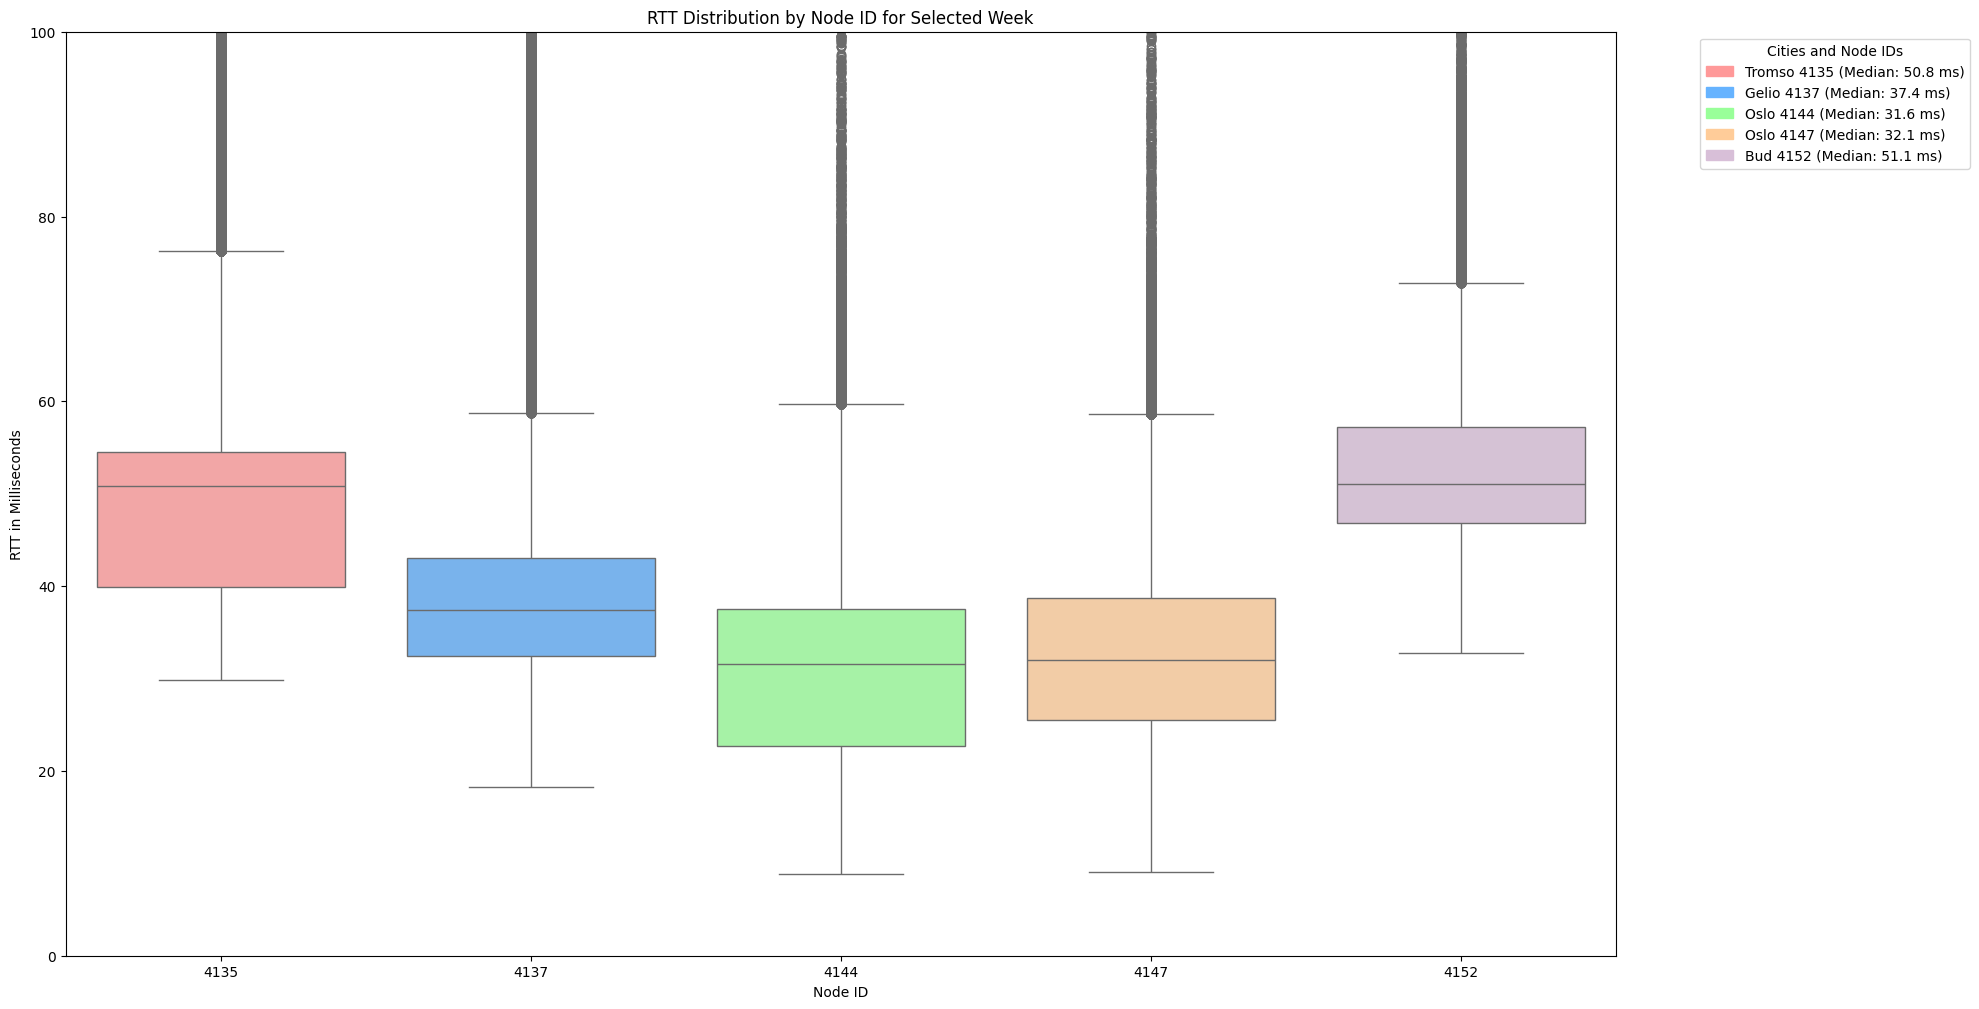

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches

# Define custom colors for each box (you can adjust these as needed)
custom_colors = ['#FF9999', '#66B3FF', '#99FF99', '#FFCC99', '#D8BFD8']  # Added a fifth color

# Your existing code for creating the box plot
plt.figure(figsize=(20, 12))
ax = sns.boxplot(data=plot_data, x='node_id', y='rtt', palette=custom_colors)

# Create legend labels
legend_labels = [
    f'{city_dict.get(node_id, "City")} {node_id} (Median: {median:.1f} ms)'
    for node_id, median in stats['rtt_median'].items()
]

# Create legend handles
handles = [mpatches.Patch(color=color, label=label) for color, label in zip(custom_colors, legend_labels)]

# Add legend to the plot
plt.title('RTT Distribution by Node ID for Selected Week')
plt.xlabel('Node ID')
plt.ylabel('RTT in Milliseconds')
plt.legend(handles=handles, title='Cities and Node IDs', loc='upper left', bbox_to_anchor=(1.05, 1))

# Adjust y-axis limit for better visualization
plt.ylim(0, 100)

# Show the plot
plt.show()



<ipython-input-26-1a084d4e1a42>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(data=plot_data, x='node_id', y='rtt', palette='Set2')


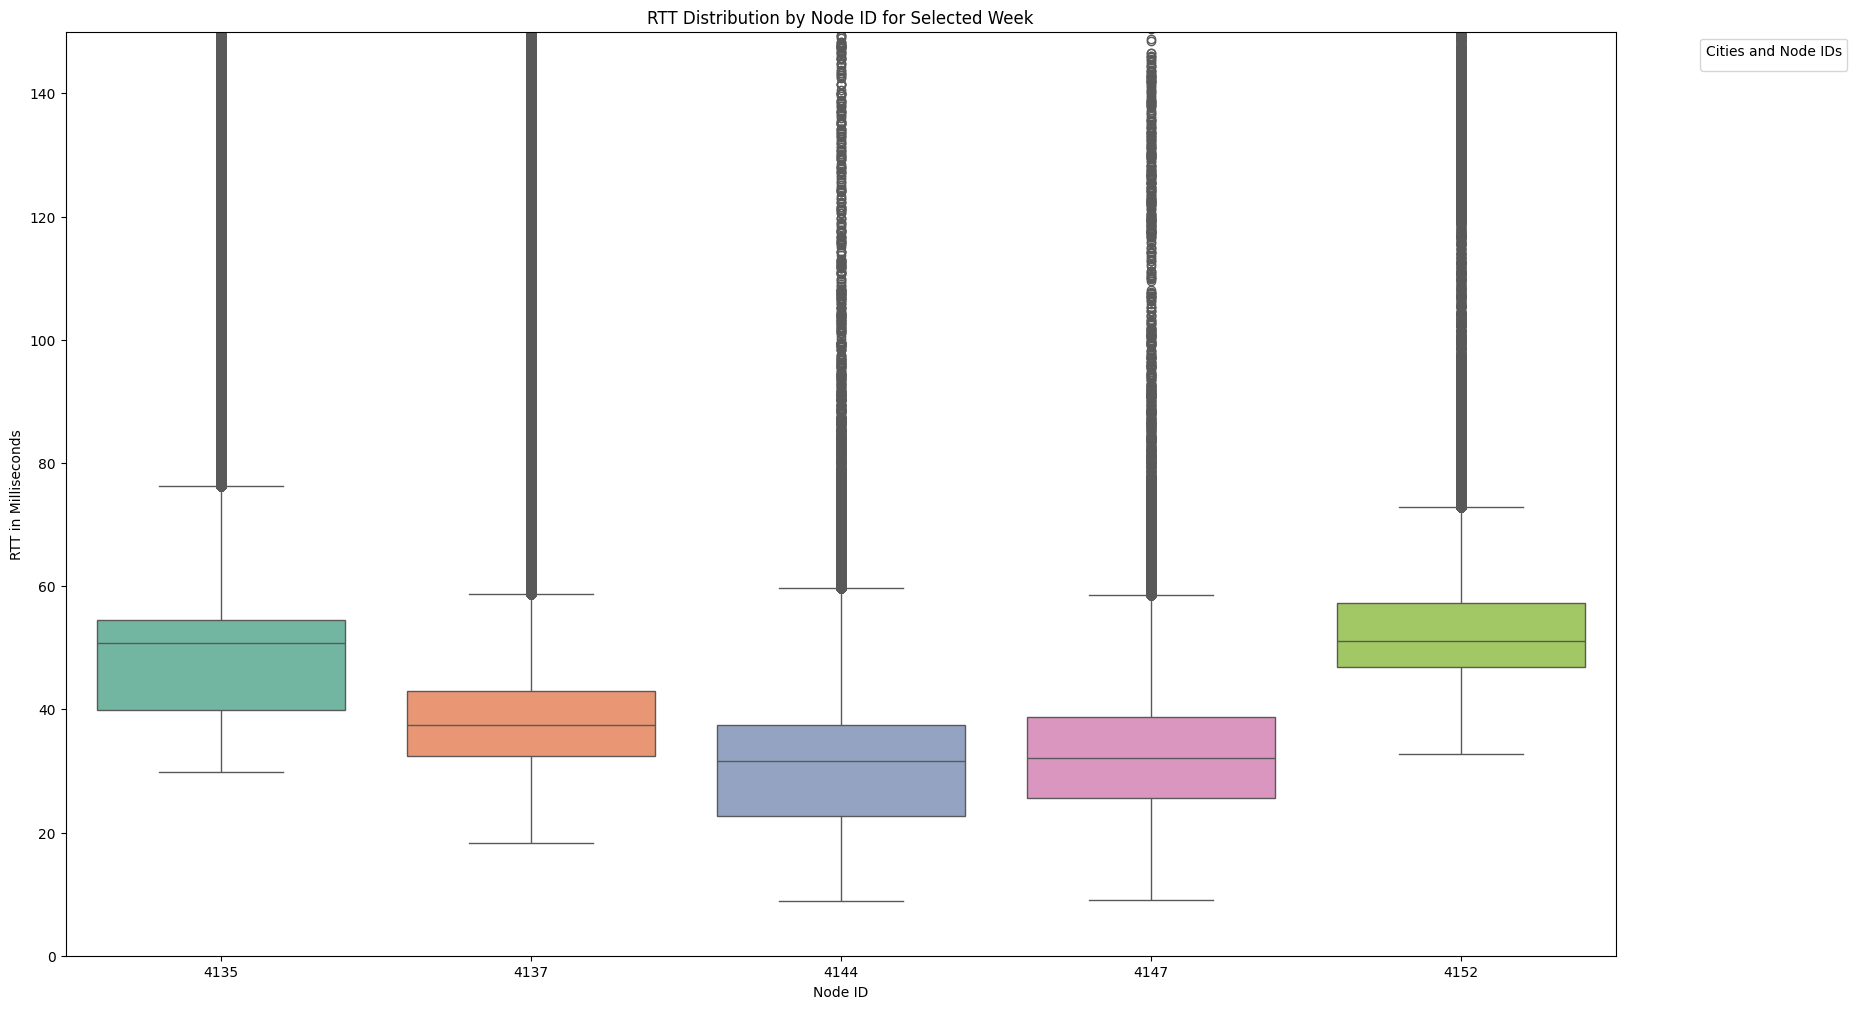

In [ ]:
import matplotlib.patches as mpatches
plt.figure(figsize=(20, 12))
ax = sns.boxplot(data=plot_data, x='node_id', y='rtt', palette='Set2')


legend_labels = [
    f'{city_dict.get(node_id, "City")} {node_id} (Median: {median:.1f} ms)'
    for node_id, median in stats['rtt_median'].items()
]
colors = [patch.get_facecolor() for patch in ax.artists]  # 'artists' contain the box patch objects
handles = [mpatches.Patch(color=color, label=label) for color, label in zip(colors, legend_labels)]


plt.title('RTT Distribution by Node ID for Selected Week')
plt.xlabel('Node ID')
plt.ylabel('RTT in Milliseconds')
plt.legend(handles=handles, title='Cities and Node IDs', loc='upper left', bbox_to_anchor=(1.05, 1))  # Place legend outside
plt.ylim(0, 150)  # Adjust ylim for better visualization
plt.show()

In [ ]:
plot_data

In [ ]:
legend_patches

In [ ]:
boxplot_data(plot_data,stats)

Tromso (Node 4135): The higher median RTT and wider IQR, along with many high outliers, could indicate that Tromso has a less stable network or higher latency issues compared to the other locations. This might be due to geographical challenges, infrastructure, or the quality of internet service provided.

Oslo (Nodes 4144 and 4147): The nodes in Oslo show lower median RTT values and a tighter IQR, which implies more consistent and potentially faster network performance. Among the two, Node 4147 seems to have the best performance with the lowest median RTT and a very tight IQR, indicating a stable and reliable connection this is reasonable as it also has the higher uptime rate of the two nodes.

Gelio (Node 4137): This node's RTT performance falls between Tromso and Oslo's nodes. It has a slightly higher median RTT than Oslo but lower than Tromso, and the spread of values is relatively moderate, with some outliers indicating occasional latency spikes.

Outliers: The individual points above and below the whiskers are outliers. These are RTT measurements that fall outside the typical range (specifically, 1.5 times the IQR above the third quartile and below the first quartile). Nodes 4135 and 4144 have a significant number of outliers, especially above the upper whisker, indicating occasional much higher RTT measurements, this could also be due to its location and having higher demands on the network in Oslo.

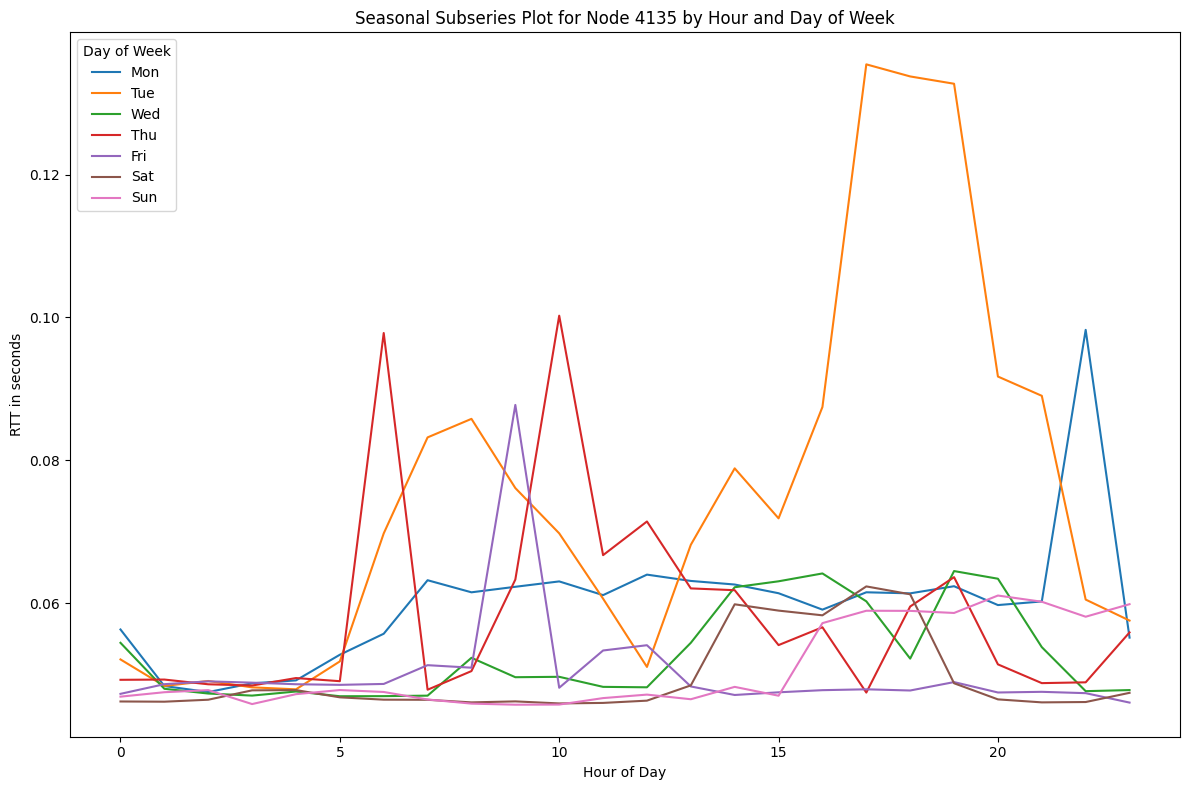

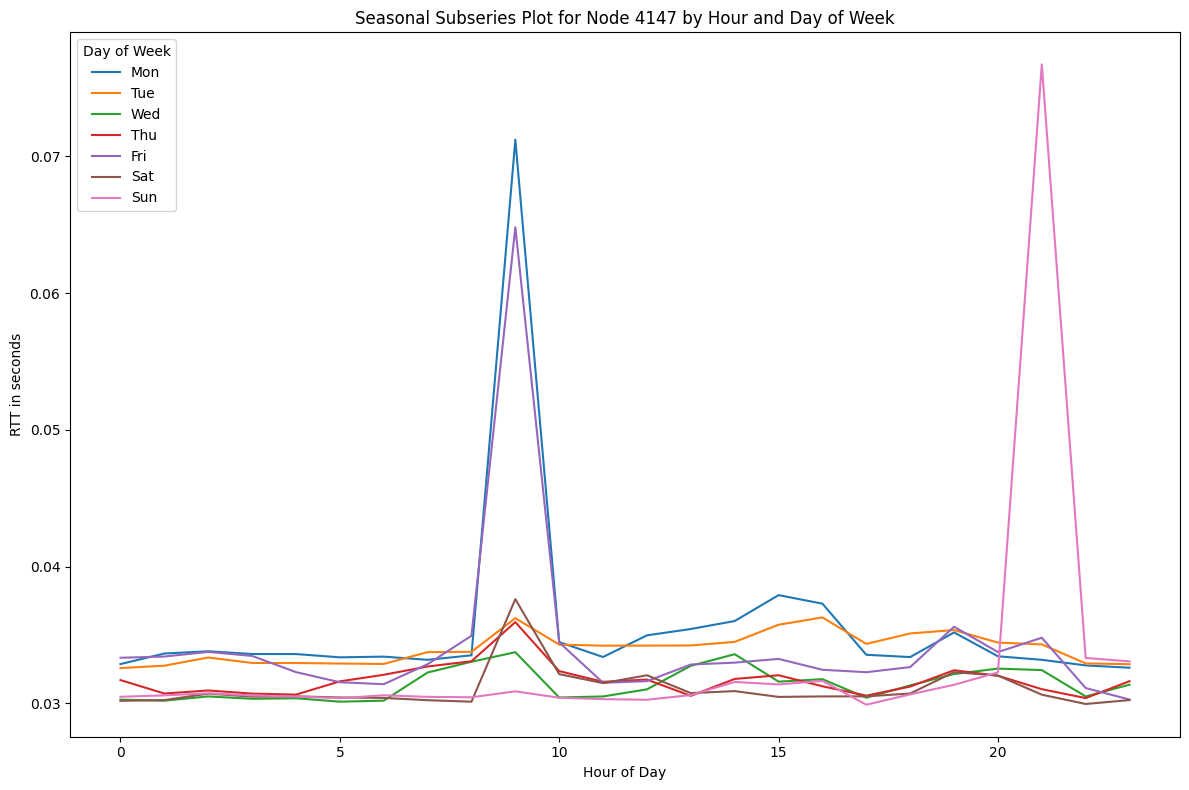

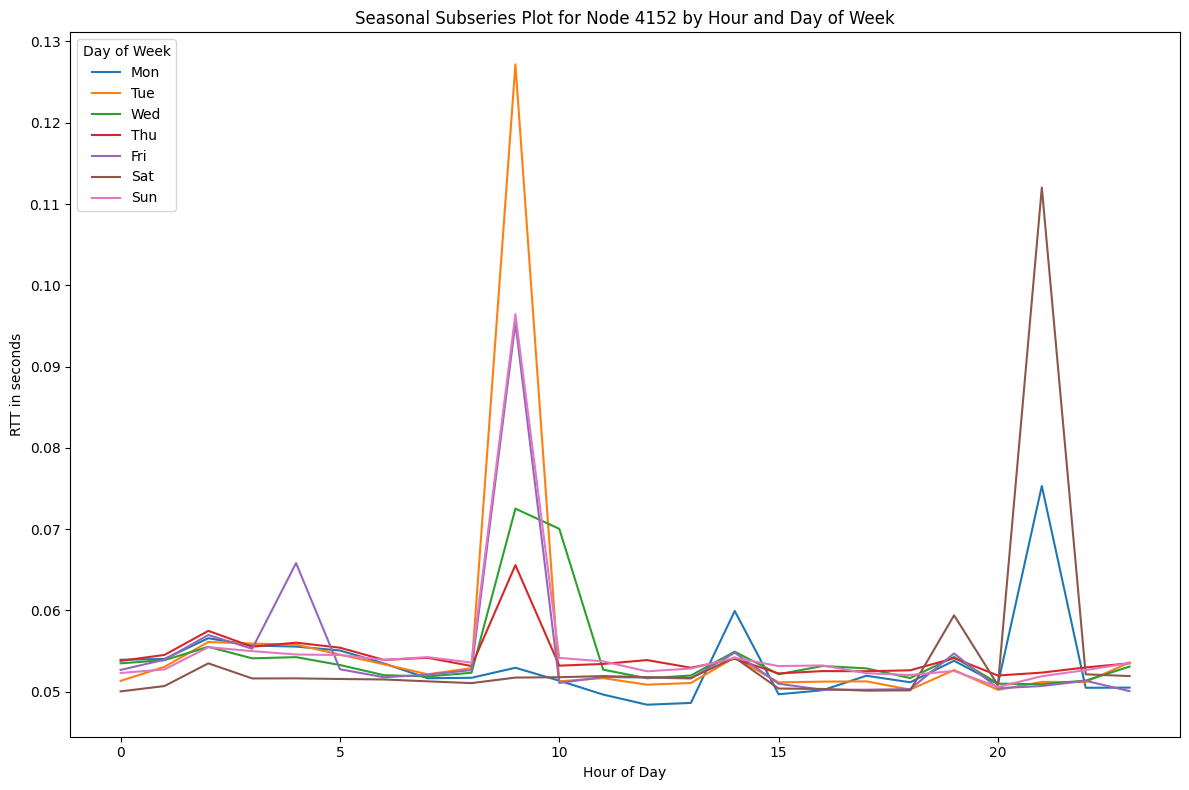

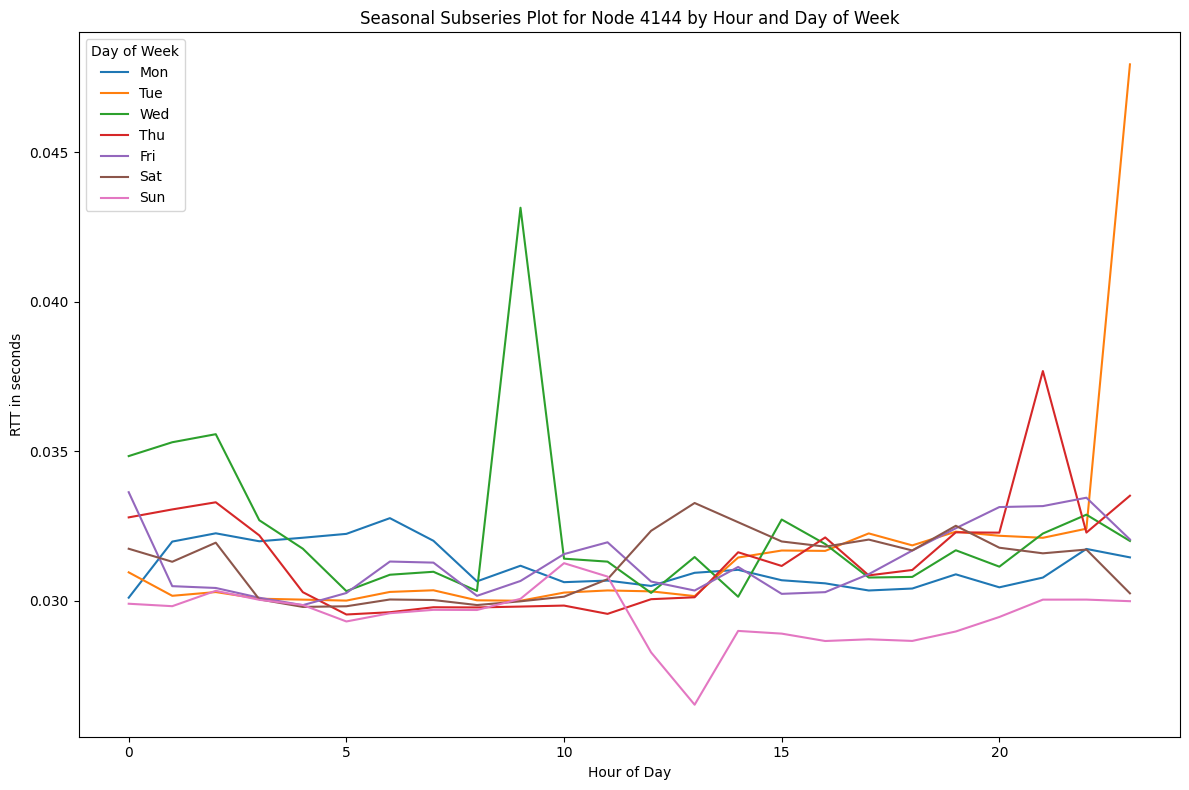

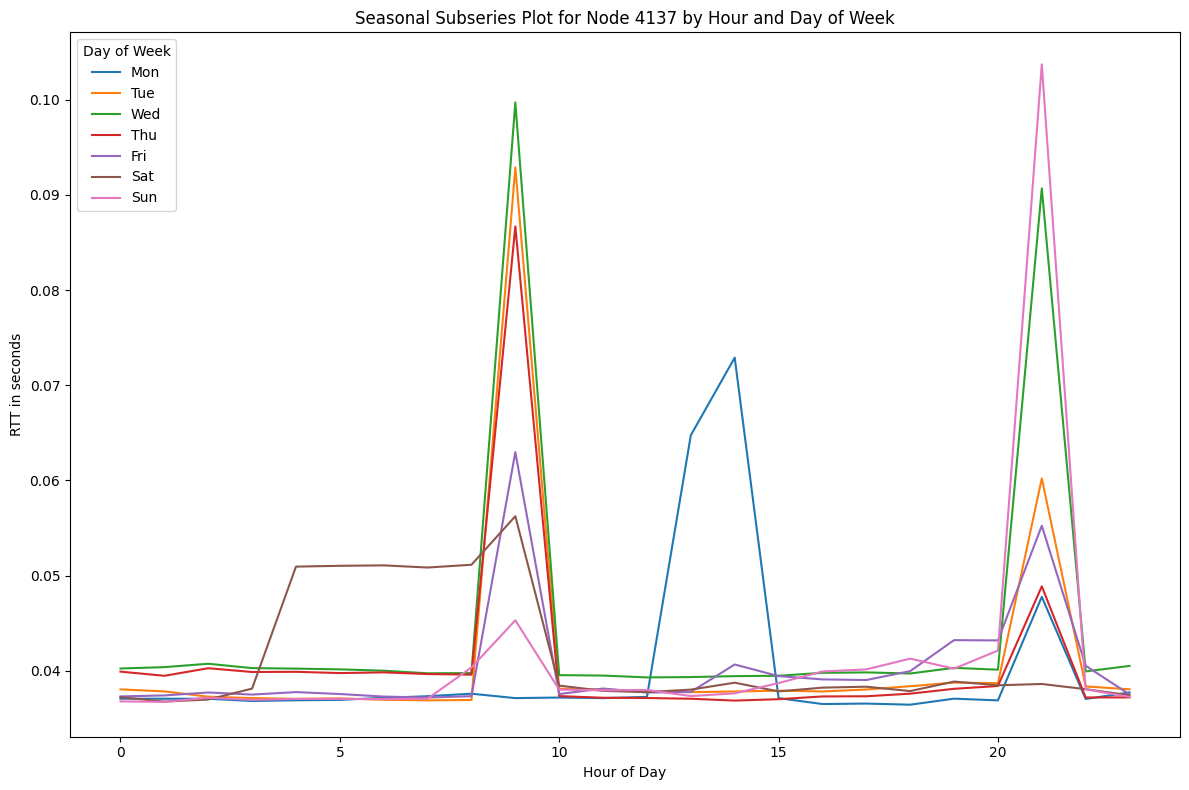

In [ ]:
seasonality_plot(plot_data)


Variability within Days: The plots show fluctuations in RTT over the hours in a day for each node. Each line represents a different day of the week.

Node 4135 (Tromso): This node shows significant variability, particularly during certain hours of certain days. There are prominent spikes on Thursday and Tuesday lesser ones on other days, indicating that RTT can be quite high at specific times, possibly due to increased network usage or other factors impacting network performance.

Node 4144 and Node 4147 (Oslo): These nodes seem to have a more stable RTT throughout the week with few notable spikes notably between 8 and 10 in the morning, suggesting more consistent network performance. however 4144 seemed to have high rtt thank most nodes that might be worth investigating.

Node 4137 (Gelio): This node also shows some fluctuation with a significant spike mostly between 8-10 of working hours and after 8pm  and smaller spikes on other days. The variability is less pronounced than in Node 4135 but more so than in the Oslo nodes.

Peak Times: The time of day when the spikes occur could indicate peak usage times or times when the network is experiencing issues. For example, if spikes occur during typical business hours, it could be related to increased demand on the network.

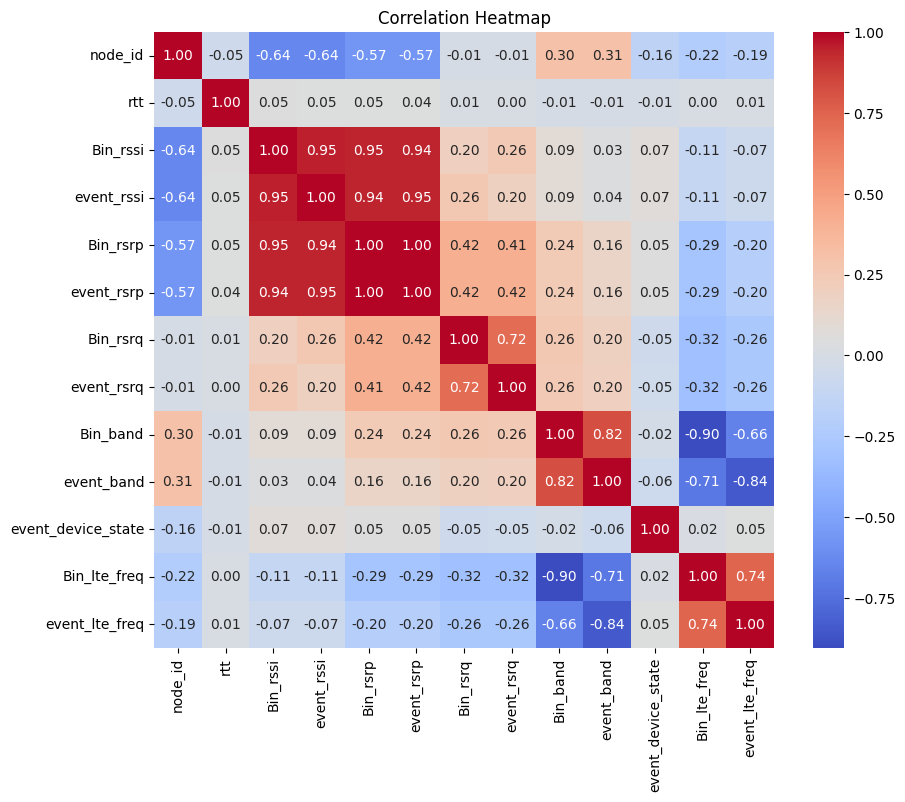

In [ ]:
correlation_plot(plot_data)

High Correlation between RSSI, RSRQ and RSRP: There is a very high positive correlation between event_rssi and event_rsrp and between Bin_rssi and Bin_rsrp (both are around 0.95), suggesting that when the signal strength (RSSI) is high, the received signal power (RSRP) is also high, and vice versa. This makes sense as they are both indicators of signal quality.

The correlation values for rtt are very close to zero with respect to rssi, rsrq and rsrp


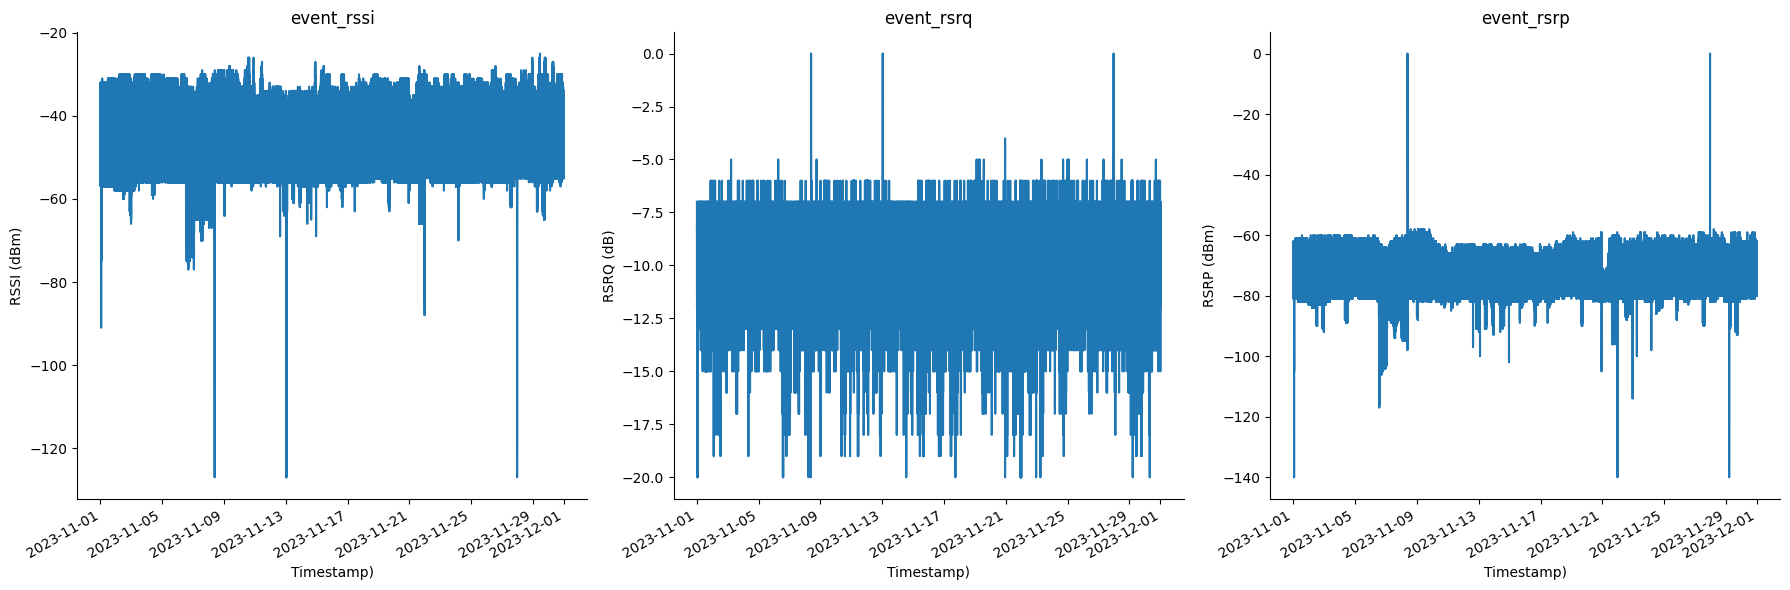

In [ ]:
plot_rtt_effects(plot_data, 'rtt', 'event_rsrp', 'event_rsrq', 'event_rssi')

event_rssi: The first plot shows RSSI over time. RSSI is a measure of the power level that a receiver senses from the signal. Generally, values closer to 0 (higher power levels) are better. The RSSI values range widely, with some periods showing stable readings around -60 dBm, which is a reasonable signal strength for mobile networks. There are several drops (spikes downward) indicating moments of significantly weaker signal strength, with values dipping below -100 dBm, which could represent periods of poor signal quality or disconnection.

event_rsrq: The second plot shows RSRQ, which is a measure of signal quality that considers both the signal strength and the interference and noise levels. The scale of RSRQ is typically from 0 to -20 dB, with values closer to 0 being better. The data shows a lot of variability, with some spikes indicating periods of potentially high interference or noise compared to the signal strength.

event_rsrp: The third plot is for RSRP, which is a more refined measure of signal power than RSSI, as it measures the power from a specific reference signal, ignoring noise and interference. In LTE systems, a good RSRP might be higher than -80 dBm, while values below -100 dBm indicate a weak signal. The data indicates RSRP values that fluctuate, sometimes going below -100 dBm, suggesting moments of poor signal reception.




In [ ]:
plot_time_series(plot_data, 'ts', 'rtt', title='RTT Plot', y_range=[0,0.2])

<ipython-input-28-4b88f7d4e79c>:14: FutureWarning:

The operation <function mean at 0x7c26f296f010> failed on a column. If any error is raised, this will raise an exception in a future version of pandas. Drop these columns to avoid this warning.



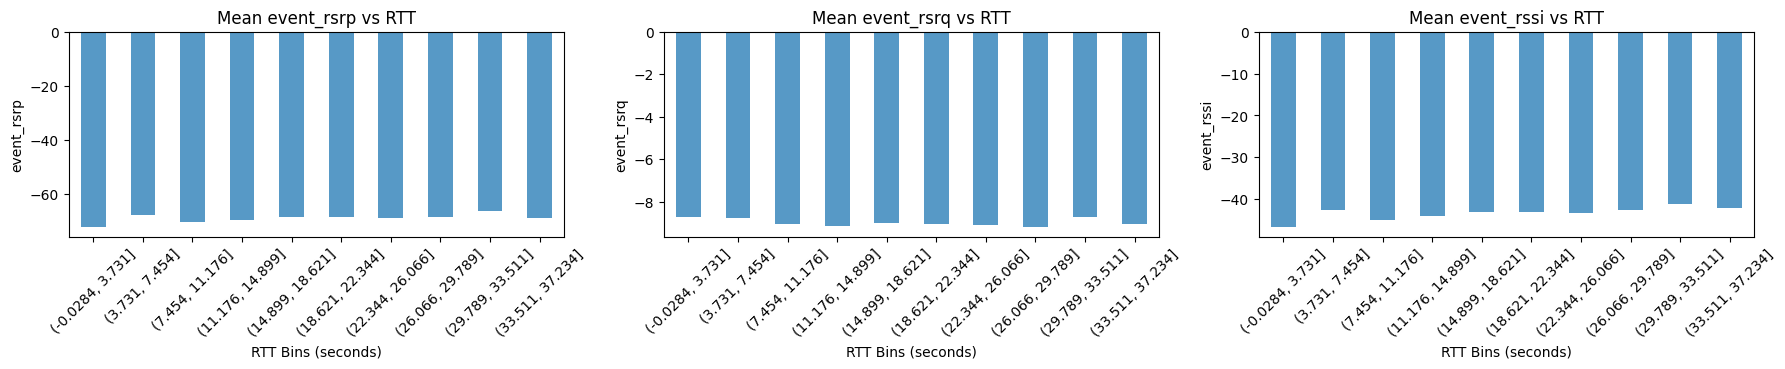

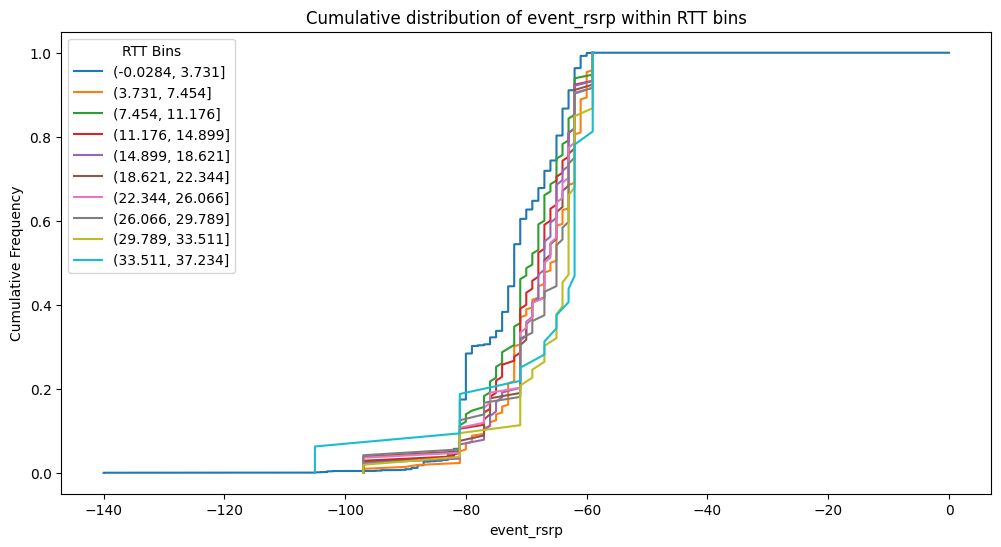

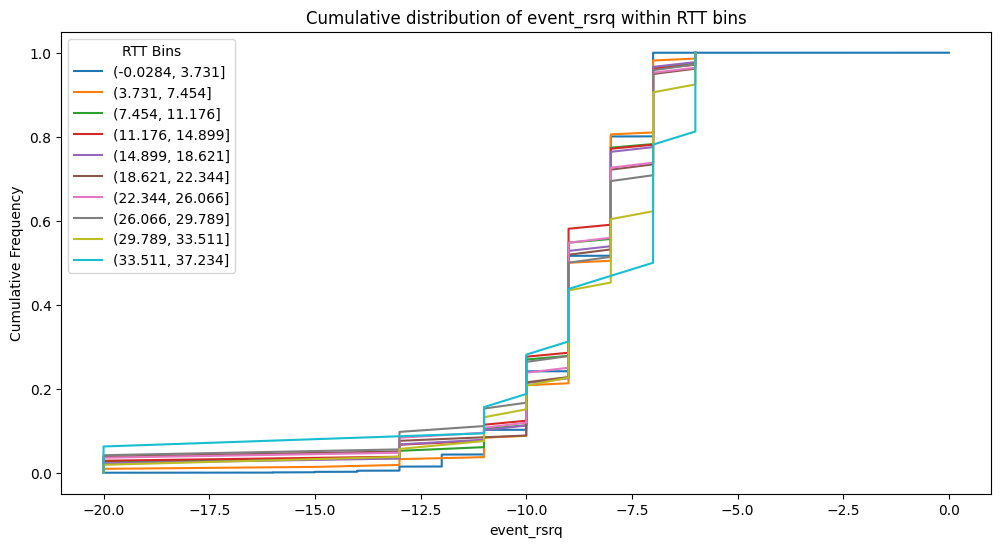

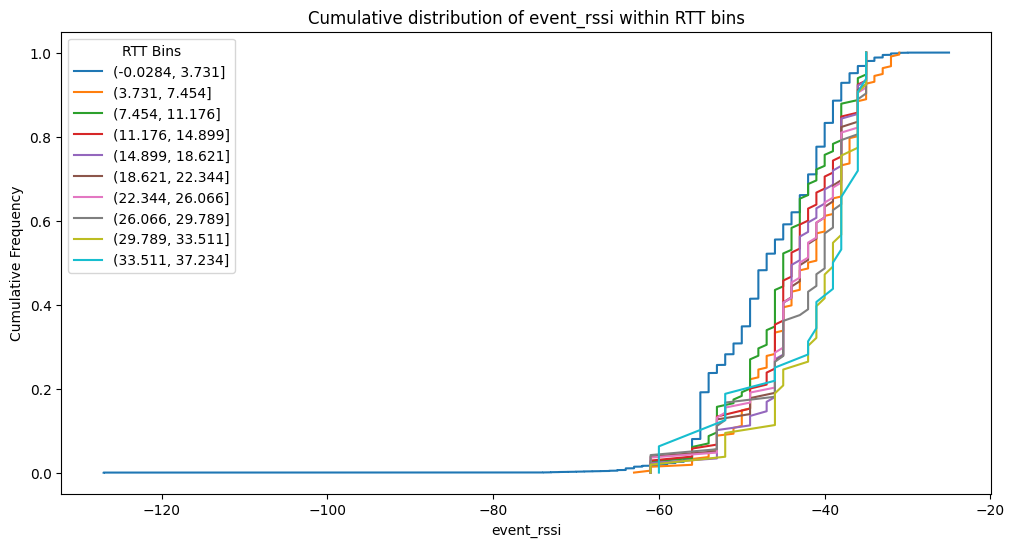

In [ ]:
plot_aggregated_metrics(plot_data, 'rtt', ['event_rsrp', 'event_rsrq', 'event_rssi'], bins=10, aggfunc=np.mean)

Barplots: These plots seem to suggest that there's no strong relationship between RTT and these signal quality metrics in the data range shown. The metrics remain relatively stable across the range of RTT values provided, which might indicate that the network maintains consistent signal quality regardless of the latency experienced.


Cummulative plots:

Cumulative Distribution of RSRP within RTT Bins:

This plot shows the distribution of RSRP values within each RTT bin.
The x-axis indicates the RSRP values, and the y-axis shows the cumulative frequency.
Each line represents an RTT bin, color-coded to distinguish between bins.
The lines are generally steeper in the higher RSRP values, which means that most of the RSRP values within each bin are concentrated in the higher signal strength range (closer to 0 dBm).
The overlapping of lines suggests similar distributions of RSRP across different RTT bins.
we can also see that the higher the RTT leads to a higher cluster of its values in higher ranges of RSRP

Cumulative Distribution of RSRQ within RTT Bins:

This plot shows the cumulative distribution of RSRQ values.
The RSRQ values are on the x-axis, ranging from about -20 dB to 0 dB, with 0 dB being the best possible signal quality.
The plot indicates that for all RTT bins, the RSRQ values are mostly clustered around a narrow range, with the distribution lines rising steeply and then plateauing.
This suggests that within each RTT bin, the RSRQ values are relatively consistent. however as is the case with RSRP we can also see that for higher values in rtt the values in RSRQ are concentrated in the right side with High RSRQ

Cumulative Distribution of RSSI within RTT Bins:

The third plot is similar to the first but for RSSI values, which measure signal strength but can be more influenced by noise.
The lines in this plot are less steep compared to the RSRP plot, which suggests a wider distribution of RSSI values within each RTT bin.
Like the RSRP plot, there's a notable overlap in distributions across RTT bins.
and also as it is the case larger rtt values are concentrated on right side.


In [ ]:
def detect_anomalies_with_iforest(df, window_size=24, value_column='value'):

    df.set_index('ts')

    # Calculate rolling window features
    df['rolling_mean'] = df[value_column].rolling(window=window_size).mean()
    df['rolling_std'] = df[value_column].rolling(window=window_size).std()

    # Drop rows with NaN values resulting from rolling window calculation
    df_clean = df.dropna()

    # Extract features for anomaly detection
    X = df_clean[['rolling_mean', 'rolling_std']].values

    # Normalize the features
    scaler = StandardScaler()
    X_normalized = scaler.fit_transform(X)

    # Initialize and fit the Isolation Forest model
    model = IForest(contamination= 0.005, max_samples = 0.8,
                    n_estimators = 200)
    model.fit(X_normalized)

    # Predict the outliers
    outliers_predicted = model.predict(X_normalized)

    # Add the predictions to the original DataFrame
    df_clean['anomaly'] = outliers_predicted

    # Filter and return the detected anomalies
    df_anomalies = df_clean[df_clean['anomaly'] == 1]
    return df_anomalies

In [ ]:
anomalies_data = detect_anomalies_with_iforest(plot_data, 50, 'rtt')

In [ ]:
anomalies_data


In [ ]:

def plot_time_series3(df, anomalies_df, value_col, title='RTT Plot', y_range=None):
    # Ensure the timestamp is in datetime format if it's not already
    df.index = pd.to_datetime(df.index)
    df = df.resample('T').mean().reset_index()
    anomalies_df.index = pd.to_datetime(anomalies_df.index)

    # Create the main time series plot using the original DataFrame
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=df.index, y=df[value_col], mode='lines', name='Values'))

    # Add anomalies to the plot
    # Ensure anomaly markers are correctly placed by directly using the anomalies DataFrame
    fig.add_trace(go.Scatter(x=anomalies_df.index, y=anomalies_df[value_col], mode='markers', name='Anomalies', marker=dict(color='red', size=10)))

    # Update the layout with title and range slider
    fig.update_layout(title=title, xaxis=dict(rangeslider=dict(visible=True), type="date"))

    # Update Y-axis range if specified
    if y_range is not None:
        fig.update_yaxes(range=y_range)

    # Show the plot
    fig.show()



In [ ]:
plot_time_series3(plot_data, anomalies_data, 'rtt', title='RTT Plot', y_range=None)

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

def plot_cdf(df, val, m):
    # Assuming 'ts' is the index after loading the data
    rtt_sorted = df[val].sort_values()
    cdf = rtt_sorted.rank(method='average', pct=True)

    # Convert RTT from seconds to milliseconds
    rtt_sorted *= 1000

    # Plotting the CDF with a focus on a specific range and logarithmic x-axis
    plt.figure(figsize=(14, 5))
    plt.plot(rtt_sorted, cdf, marker='.', linestyle='none', alpha=0.5)

    # Set the limits of the x-axis to zoom in on the area of interest
    plt.xlim(left=0, right=100)  # Adjust these values based on your data (scaled by 1000)

    # Set x-axis major locator
    plt.gca().xaxis.set_major_locator(MultipleLocator(5))

    plt.xlabel('RTT Values (Milliseconds)')
    plt.ylabel('CDF')
    plt.title(f'RTT Distribution {m}')
    plt.grid(True)
    plt.show()

# Example usage:
# Assuming 'df' is your DataFrame and 'val' is the column name for RTT values
# plot_cdf(df, 'rtt_column_name', 'Mode X')

In [ ]:
def plot_cdf2(df, val,m):
    # Assuming 'ts' is the index after loading the data
    rtt_sorted = df[val].sort_values()
    cdf = rtt_sorted.rank(method='average', pct=True)

    # Plotting the CDF with a focus on a specific range and logarithmic x-axis
    plt.figure(figsize=(14, 5))
    plt.plot(rtt_sorted, cdf, marker='.', linestyle='none', alpha=0.5)

    # Set the limits of the x-axis to zoom in on the area of interest
    plt.xlim(left=0, right=0.1)  # Adjust these values based on your data

    plt.gca().xaxis.set_major_locator(MultipleLocator(5))

    plt.xlabel('RTT Values')
    plt.ylabel('CDF')
    plt.title(f'RTT Distribution {m}')
    plt.grid(True)
    plt.show()

In [ ]:
plot_data

,ts,node_id,rtt,event_rssi,event_rsrp,event_rsrq,event_band,event_device_state,event_lte_freq
0,2023-11-01 00:00:00.252449,4135,57.562,-45.0,-68.0,-7.0,8.0,3.0,900.0
7645376,2023-11-01 00:00:00.254651,4147,33.347,-49.0,-73.0,-7.0,20.0,3.0,800.0
10200137,2023-11-01 00:00:00.372102,4152,51.132,-80.0,-112.0,-12.0,3.0,3.0,1800.0
5093777,2023-11-01 00:00:00.448629,4144,19.667,-51.0,-81.0,-10.0,20.0,3.0,800.0
2532325,2023-11-01 00:00:00.630068,4137,44.847,-39.0,-62.0,-8.0,20.0,3.0,800.0
...,...,...,...,...,...,...,...,...,...
2532324,2023-11-30 23:59:59.253503,4135,53.393,-41.0,-65.0,-8.0,20.0,2.0,800.0
7645375,2023-11-30 23:59:59.328843,4144,43.597,-55.0,-79.0,-9.0,20.0,3.0,800.0
10200136,2023-11-30 23:59:59.405607,4147,31.136,-48.0,-71.0,-7.0,20.0,3.0,800.0
5093776,2023-11-30 23:59:59.685685,4137,30.499,-38.0,-63.0,-8.0,20.0,3.0,800.0


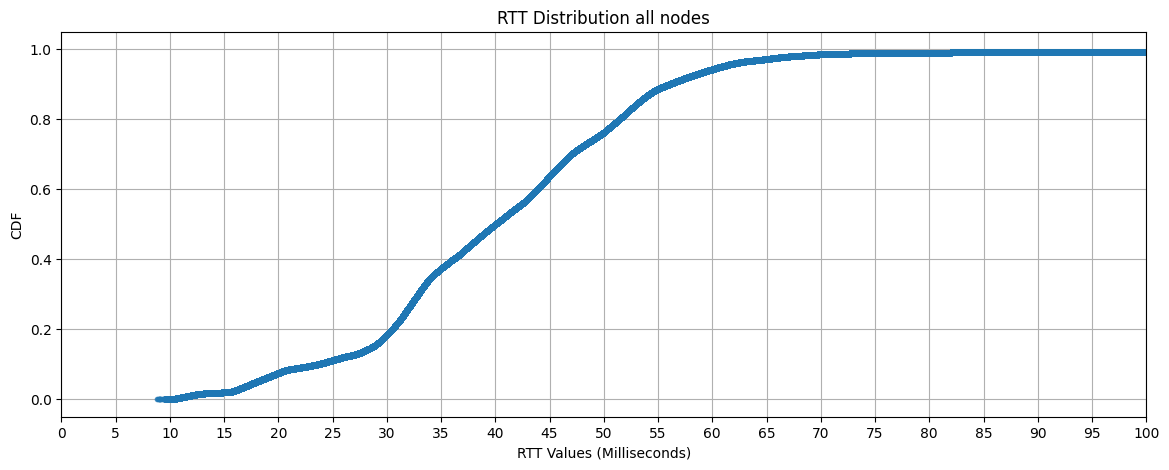

In [ ]:
plot_cdf(plot_data, 'rtt', 'all nodes')

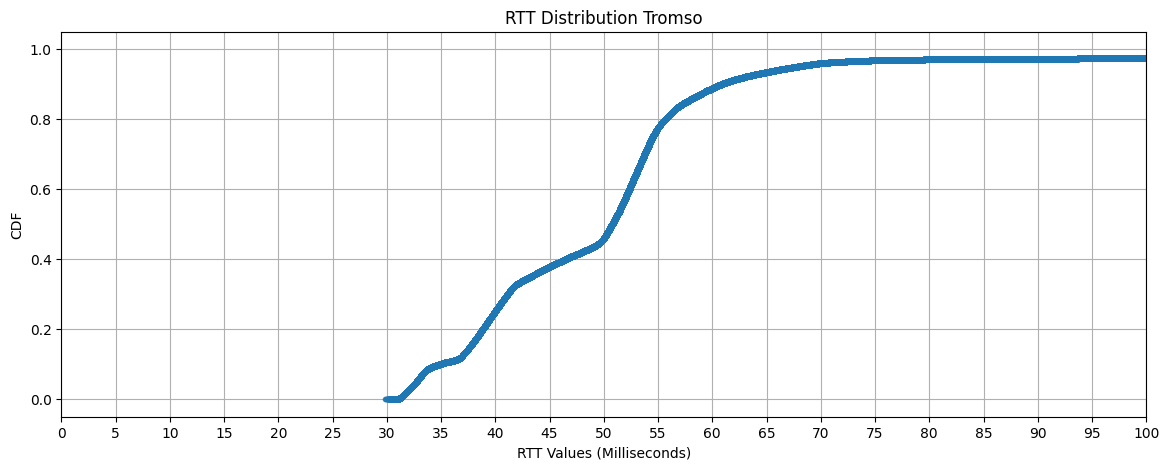

In [ ]:
plot_cdf(tromso_4135_c, 'rtt', 'Tromso 4135')

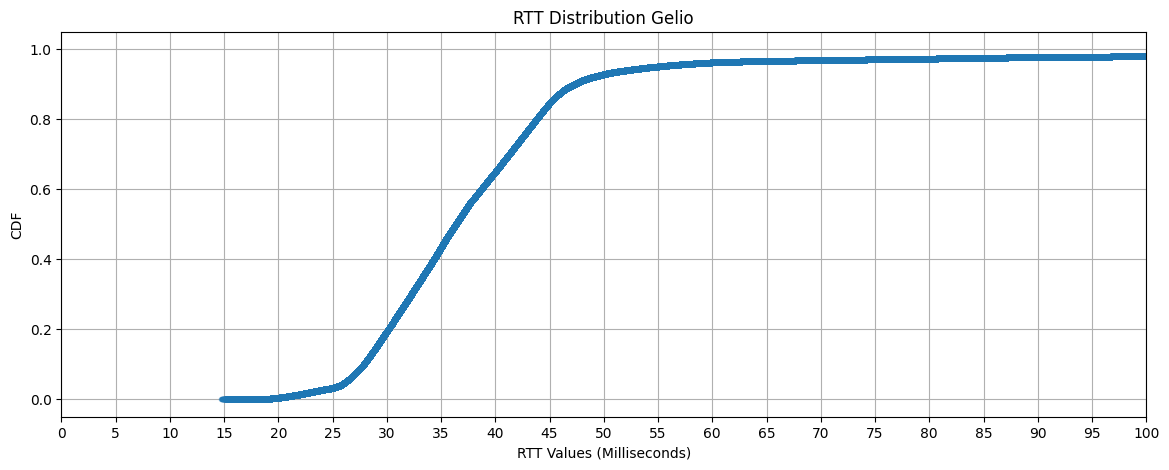

In [ ]:
plot_cdf(gelio_4137_c, 'rtt', 'Gelio')

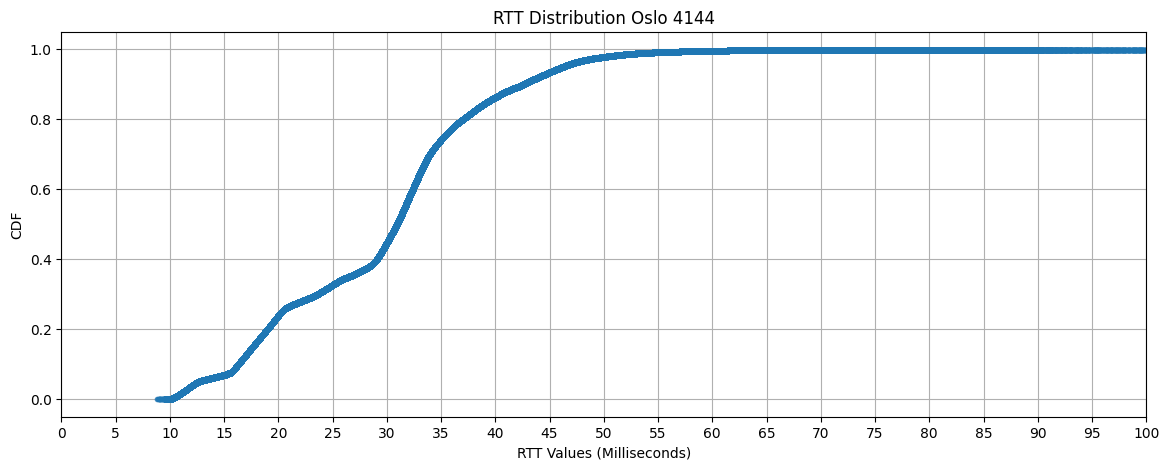

In [ ]:
plot_cdf(oslo_4144_c, 'rtt', 'Oslo 4144')

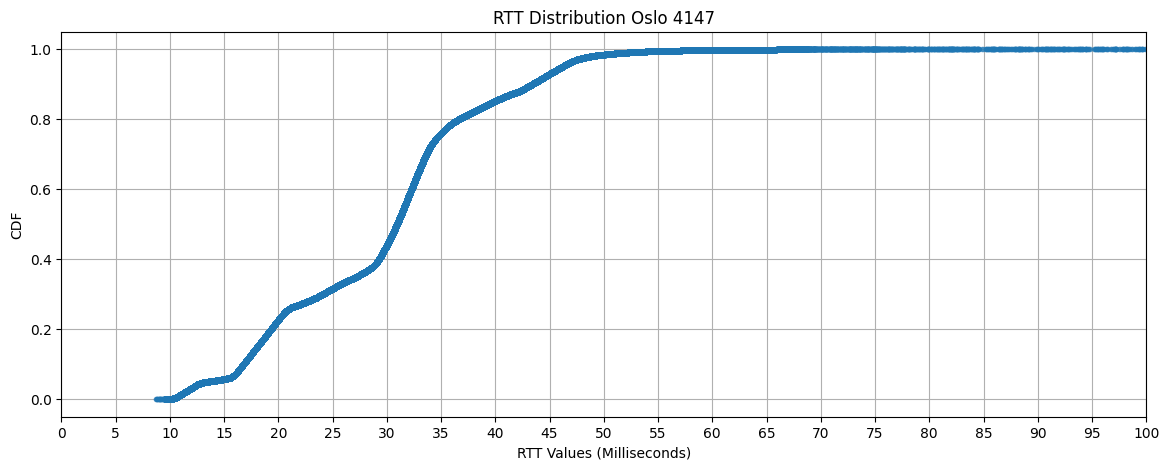

In [ ]:
plot_cdf(oslo_4147_c, 'rtt', 'Oslo 4147')

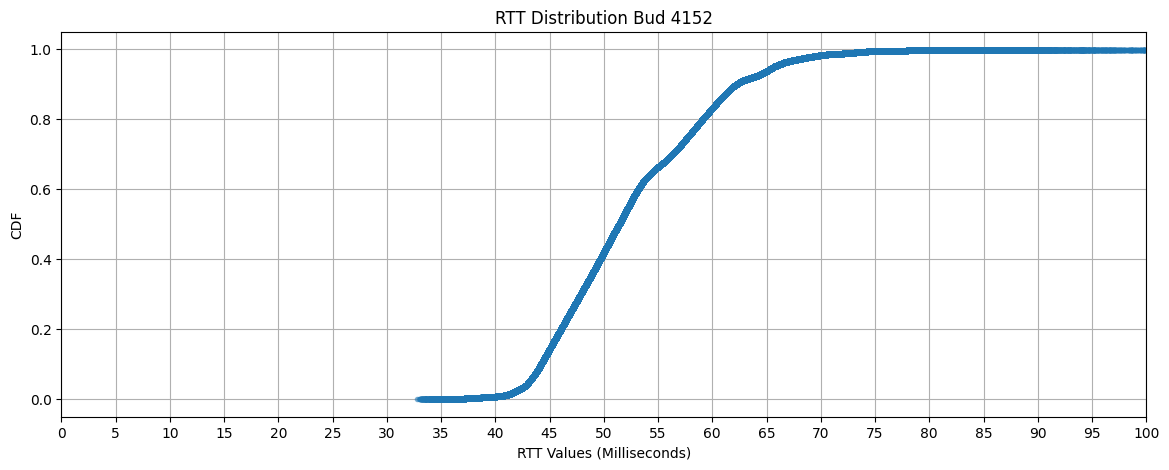

In [ ]:
plot_cdf(bud_4152, 'rtt', 'Bud 4152')

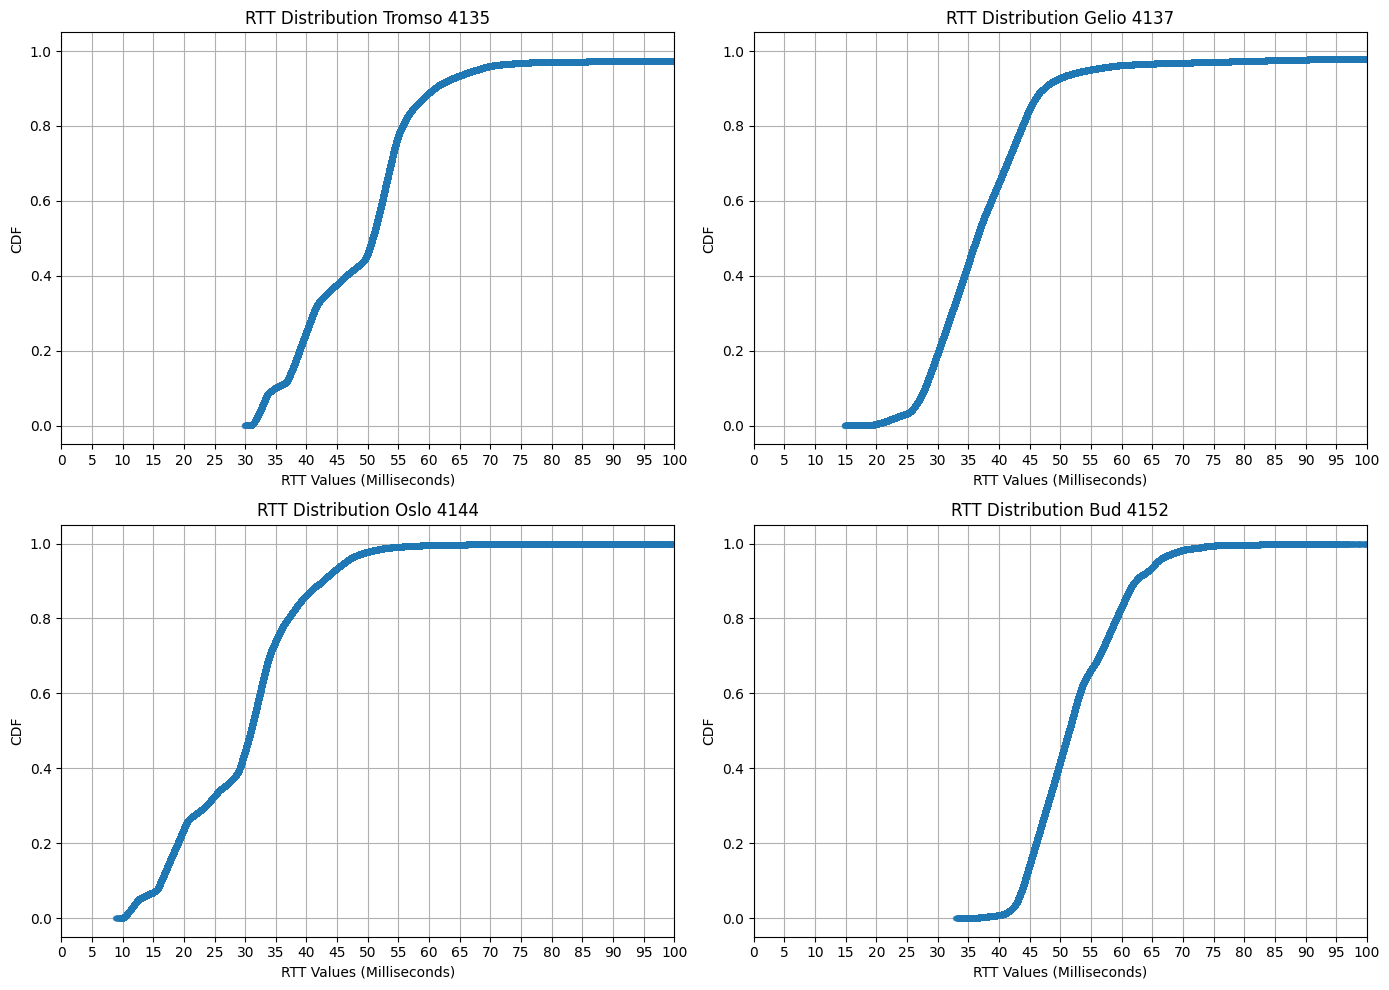

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

def plot_cdf(df, val, m, ax):
    rtt_sorted = df[val].sort_values()
    cdf = rtt_sorted.rank(method='average', pct=True)
    rtt_sorted *= 1000
    ax.plot(rtt_sorted, cdf, marker='.', linestyle='none', alpha=0.5)
    ax.set_xlim(left=0, right=100)
    ax.xaxis.set_major_locator(MultipleLocator(5))
    ax.set_xlabel('RTT Values (Milliseconds)')
    ax.set_ylabel('CDF')
    ax.set_title(f'RTT Distribution {m}')
    ax.grid(True)

fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# Plot each CDF on a different subplot
plot_cdf(tromso_4135_c, 'rtt', 'Tromso 4135', axs[0, 0])
plot_cdf(gelio_4137_c, 'rtt', 'Gelio 4137', axs[0, 1])
plot_cdf(oslo_4144_c, 'rtt', 'Oslo 4144', axs[1, 0])
plot_cdf(bud_4152, 'rtt', 'Bud 4152', axs[1, 1])

# Adjust the layout so that there is no overlap between subplots
plt.tight_layout()
plt.show()